/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


> Average Accuracy across 10-folds: 94.47% (+/- 0.31%)


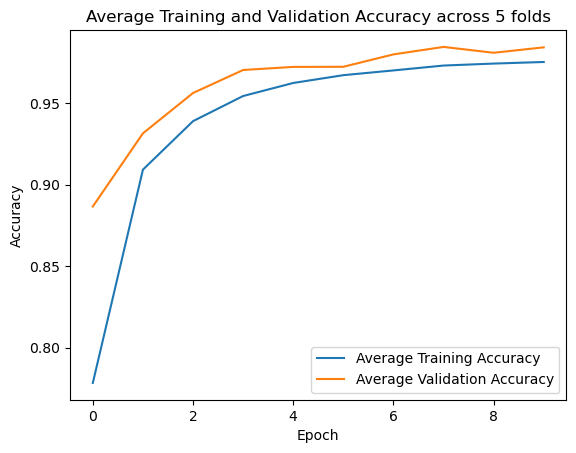

                   precision    recall  f1-score   support

          feature       0.93      0.76      0.84       641
  user_experience       0.87      0.88      0.88      2388
            issue       0.91      0.65      0.76       699
other_information       0.93      0.97      0.95      8359

         accuracy                           0.92     12087
        macro avg       0.91      0.81      0.85     12087
     weighted avg       0.92      0.92      0.92     12087



In [6]:


import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

# 1. Load and Preprocess the dataset
df = pd.read_csv('requirment.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['Base_Reviews'] = df['Base_Reviews'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Base_Reviews'])
X = tokenizer.texts_to_sequences(df['Base_Reviews'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)

y_dict = {'feature': 0, 'user_experience': 1, 'issue': 2, 'other_information': 3}
y = df['category'].map(y_dict)
y = pd.get_dummies(df['category']).values

# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the BiGRU model
def create_bigru_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Bidirectional(GRU(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_bigru_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 5 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
#y_pred = model.predict(X_resampled)
#y_pred_classes = np.argmax(y_pred, axis=1)
#y_true_classes = np.argmax(y_resampled, axis=1)
#cm = confusion_matrix(y_true_classes, y_pred_classes)
#sns.heatmap(cm, annot=True, fmt='g')
#plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))
